In [1]:
from lora.models.roberta_scratch import get_model
from omegaconf import OmegaConf

from transformers import RobertaTokenizer

from datasets import load_dataset
from torch.utils.data import DataLoader

import scipy as scp
import matplotlib.pyplot as plt

import numpy as np

import torch
import torch.nn as nn

import math

from copy import deepcopy

/cis/home/adesilva/miniconda3/envs/myllm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [83]:
args = OmegaConf.load("../config.yaml")
weights_path = "../outputs/2024-04-25/08-40-45/scratch.pth"
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

model = get_model(args)
model.load_state_dict(torch.load(weights_path))
model.to(device)

# for p in model.parameters():
#     p.requires_grad = False

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

loading file vocab.json from cache at /cis/home/adesilva/.cache/huggingface/hub/models--roberta-base/snapshots/e2da8e2f811d1448a5b465c236feacd80ffbac7b/vocab.json
loading file merges.txt from cache at /cis/home/adesilva/.cache/huggingface/hub/models--roberta-base/snapshots/e2da8e2f811d1448a5b465c236feacd80ffbac7b/merges.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /cis/home/adesilva/.cache/huggingface/hub/models--roberta-base/snapshots/e2da8e2f811d1448a5b465c236feacd80ffbac7b/tokenizer_config.json
loading file tokenizer.json from cache at /cis/home/adesilva/.cache/huggingface/hub/models--roberta-base/snapshots/e2da8e2f811d1448a5b465c236feacd80ffbac7b/tokenizer.json
loading configuration file config.json from cache at /cis/home/adesilva/.cache/huggingface/hub/models--roberta-base/snapshots/e2da8e2f811d1448a5b465c236feacd80ffbac7b/config.json
Model config RobertaConfig {
  "_

In [3]:
dataset = load_dataset("nyu-mll/glue", "sst2")
dataset = dataset.map(
    lambda e: tokenizer(
        e["sentence"],
        None,
        max_length=256,
        pad_to_max_length=True,
        return_token_type_ids=True,
    ),
    batched=True,
)
dataset.set_format(
            type="torch",
            columns=["input_ids", "token_type_ids", "attention_mask", "label"],
        )
dataloader = DataLoader(
            dataset["validation"],
            batch_size=16,
            shuffle=False,
            num_workers=4
)

In [5]:
model

RoBERTaClassifier(
  (roberta_encoder): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768, padding_idx=1)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNo

In [49]:
# add a hook to get the token embeddings
activation = {}
def get_embeddings(name):
    def hook(model, input, output):
        activation[name] = output
    return hook
model.roberta_encoder.embeddings.register_forward_hook(get_embeddings('embeddings'))

In [50]:
data = next(iter(dataloader))
out = model(
    input_ids=data["input_ids"].long().to(device),
    attention_mask=data["attention_mask"].long().to(device),
    token_type_ids=data["token_type_ids"].long().to(device)
)

In [ ]:
model.roberta_encoder.get_extended_attention_mask()

In [17]:
# get an embedded token sequence
X = activation["attention"]

In [95]:
# get weights of the ith layer
query = model.roberta_encoder.encoder.layer[0].attention.self.query
key = model.roberta_encoder.encoder.layer[0].attention.self.key
value = model.roberta_encoder.encoder.layer[0].attention.self.value

Wq = torch.vstack([query.weight.transpose(0, 1), query.bias]).cpu().numpy()
Wk = torch.vstack([key.weight.transpose(0, 1), key.bias]).cpu().numpy()
B = Wq @ Wk.T

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, '$B = W_Q W_K^\\top$')

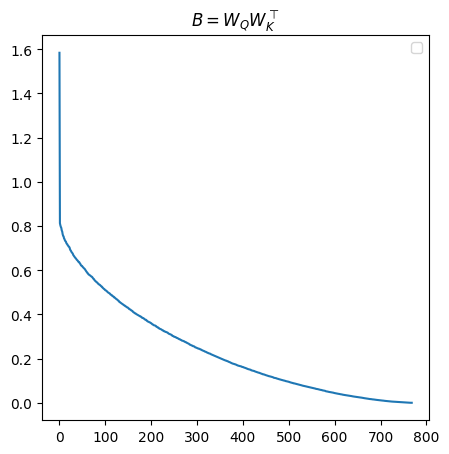

In [96]:
# plot spectrum of B
S = scp.linalg.svdvals(B)
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(list(range(len(S))), S)
ax.legend()
ax.set_title(r"$B = W_Q W_K^\top$")

In [97]:
# get an embedded token sequence
X = activation["embeddings"][15].cpu()
x = torch.cat([X, torch.ones(X.size()[:-1] + (1,))], dim=-1).numpy()

Y = scp.special.softmax(x @ B @ x.T / np.sqrt(B.shape[0])) 

Text(0.5, 1.0, 'Attn. scores with $B$')

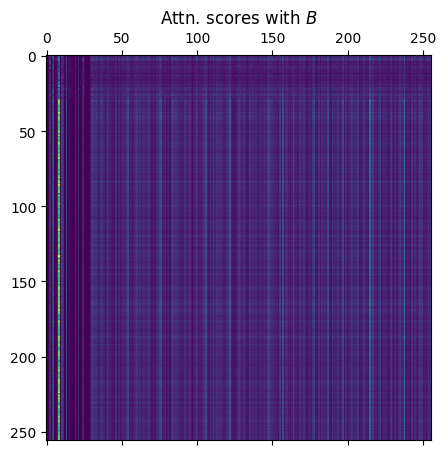

In [98]:
fig, axes = plt.subplots(figsize=(5, 5))
ax = axes
ax.matshow(Y)
ax.set_title(r"Attn. scores with $B$")

# ax = axes[1]
# ax.matshow(Y)
# ax.set_title(r"Attn. scores with $\hat B = UV + S$")
# plt.show()

In [111]:
B_list = []
for i in range(6):
    query = model.roberta_encoder.encoder.layer[0].attention.self.query
    key = model.roberta_encoder.encoder.layer[0].attention.self.key
    value = model.roberta_encoder.encoder.layer[0].attention.self.value

    Wq = torch.vstack([query.weight.transpose(0, 1), query.bias]).cpu().numpy()
    Wk = torch.vstack([key.weight.transpose(0, 1), key.bias]).cpu().numpy()
    B = Wq @ Wk.T

    B_list.append(B)
B_list = np.stack(B_list)
scp.io.savemat("B_list.mat", {"B": B_list})

In [116]:
scp.io.savemat("token_seq.mat", {"x": x})

In [125]:
Bhat_list = scp.io.loadmat("Bhat_list.mat")['Bhat_list']

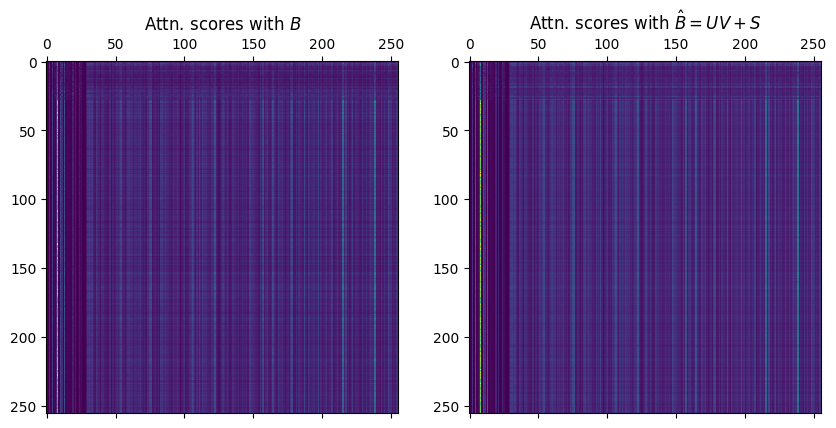

In [131]:
# get an embedded token sequence
X = activation["embeddings"][15].cpu()
x = torch.cat([X, torch.ones(X.size()[:-1] + (1,))], dim=-1).numpy()

Y = scp.special.softmax(x @ B_list[0] @ x.T / np.sqrt(B.shape[0])) 
Yhat = scp.special.softmax(x @ Bhat_list[0] @ x.T / np.sqrt(B.shape[0])) 

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax = axes[0]
ax.matshow(Y)
ax.set_title(r"Attn. scores with $B$")

ax = axes[1]
ax.matshow(Yhat)
ax.set_title(r"Attn. scores with $\hat B = UV + S$")
plt.show()

In [226]:
class SelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.B = torch.randn((config.hidden_size+1, config.hidden_size+1))

        # self.query = nn.Linear(config.hidden_size, self.all_head_size)
        # self.key = nn.Linear(config.hidden_size, self.all_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)

        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        past_key_value=None,
        output_attentions=False,
    ):
        # key_layer = self.transpose_for_scores(self.key(hidden_states))
        value_layer = self.transpose_for_scores(self.value(hidden_states))
        # value_layer = self.value(hidden_states)
        # query_layer = self.transpose_for_scores(self.query(hidden_states))

        # Take the dot product between "query" and "key" to get the raw attention scores.
        # attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        X = torch.cat([hidden_states, torch.ones(hidden_states.size()[:-1] + (1,)).to(hidden_states.device)], dim=-1)
        attention_scores = torch.matmul(
                torch.matmul(X, self.B.to(X.device)),
                X.transpose(-1, -2)
            )

        # scale the attention scores
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)

        if attention_mask is not None:
            # Apply the attention mask is (precomputed for all layers in RobertaModel forward() function)
            attention_scores = attention_scores + attention_mask

        # Normalize the attention scores to probabilities.
        attention_probs = nn.Softmax(dim=-1)(attention_scores)

        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        attention_probs = self.dropout(attention_probs)

        # Mask heads if we want to
        if head_mask is not None:
            attention_probs = attention_probs * head_mask

        context_layer = torch.matmul(attention_probs, value_layer)

        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)

        outputs = (context_layer, attention_probs) if output_attentions else (context_layer,)

        return outputs

In [227]:
sa = SelfAttention(model.roberta_encoder.config)

In [228]:
x = torch.randn((16, 256, 768))
y = sa(x)

RuntimeError: shape '[16, 256, 768]' is invalid for input of size 50331648

In [213]:
approx_model = deepcopy(model)

In [218]:
for i in range(model.roberta_encoder.config.num_hidden_layers):
    old = approx_model.roberta_encoder.encoder.layer[i].attention.self
    approx_model.roberta_encoder.encoder.layer[i].attention.self = SelfAttention(model.roberta_encoder.config)
    approx_model.roberta_encoder.encoder.layer[i].attention.self.B = torch.from_numpy(Bhat_list[i]).float()
    approx_model.roberta_encoder.encoder.layer[i].attention.self.value.weight = old.value.weight
    approx_model.roberta_encoder.encoder.layer[i].attention.self.value.bias = old.value.bias

In [219]:
approx_model.to(device)
approx_model.eval()

RoBERTaClassifier(
  (roberta_encoder): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768, padding_idx=1)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): SelfAttention(
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (interm

In [220]:
from tqdm import tqdm

num_correct_preds = 0
num_test_samples = 0
progress = tqdm(enumerate(dataloader), total=len(dataloader))
with torch.no_grad():
    for i, data in progress:
        ids = data["input_ids"].long().to(device)
        token_type_ids = data["token_type_ids"].long().to(device)
        masks = data["attention_mask"].long().to(device)
        targets = data["label"].long().to(device)
        batchsize = len(targets)

        outputs = approx_model(ids, masks, token_type_ids)

        num_test_samples += batchsize
        num_correct_preds += (
            (torch.argmax(outputs, axis=1) == targets)
            .detach()
            .cpu()
            .numpy()
            .sum()
        )

        progress.set_description(f"[{i + 1}/{len(dataloader)}] ")

  0%|          | 0/55 [00:00<?, ?it/s]


RuntimeError: The size of tensor a (2) must match the size of tensor b (16) at non-singleton dimension 1

In [221]:
approx_model

RoBERTaClassifier(
  (roberta_encoder): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768, padding_idx=1)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): SelfAttention(
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (interm

In [64]:
from lora.models.roberta_scratch import get_model
from omegaconf import OmegaConf
from transformers import RobertaTokenizer
from datasets import load_dataset
from torch.utils.data import DataLoader
import scipy as scp
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import math
from copy import deepcopy
from tqdm import tqdm

class SelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.B = torch.randn((config.hidden_size+1, config.hidden_size+1))
        self.value = nn.Linear(config.hidden_size, self.all_head_size)

        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        past_key_value=None,
        output_attentions=False,
    ):
        value_layer = self.value(hidden_states)

        # Take the dot product between "query" and "key" to get the raw attention scores.
        X = torch.cat([hidden_states, torch.ones(hidden_states.size()[:-1] + (1,)).to(hidden_states.device)], dim=-1)
        attention_scores = torch.matmul(
                torch.matmul(X, self.B.to(X.device)),
                X.transpose(-1, -2)
            )

        # scale the attention scores
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)

        if attention_mask is not None:
            # Apply the attention mask is (precomputed for all layers in RobertaModel forward() function)
            attention_scores = attention_scores + attention_mask.view(attention_scores.shape[0], 1, attention_scores.shape[-1])

        # Normalize the attention scores to probabilities.
        attention_probs = nn.Softmax(dim=-1)(attention_scores)

        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        attention_probs = self.dropout(attention_probs)

        # Mask heads if we want to
        if head_mask is not None:
            attention_probs = attention_probs * head_mask

        context_layer = torch.matmul(attention_probs, value_layer)

        outputs = (context_layer, attention_probs) if output_attentions else (context_layer,)

        return outputs

def get_approx_model(model, rank=1):
    approx_model = deepcopy(model)
    for i in range(model.roberta_encoder.config.num_hidden_layers):
        old = approx_model.roberta_encoder.encoder.layer[i].attention.self

        # get the original B matrix
        Wq = torch.vstack([old.query.weight.transpose(0, 1), old.query.bias]).cpu()
        Wk = torch.vstack([old.key.weight.transpose(0, 1), old.key.bias]).cpu()
        B = (Wq @ Wk.T).cpu().detach().numpy()

        # low-rank approx
        if rank != B.shape[0]:
            U, s, Vs = scp.sparse.linalg.svds(B, k=rank, which='LM')
            U = U @ np.diag(s)
            V = Vs
            Bhat = U @ V
        else:
            Bhat = B

        approx_model.roberta_encoder.encoder.layer[i].attention.self = SelfAttention(model.roberta_encoder.config)
        approx_model.roberta_encoder.encoder.layer[i].attention.self.B = torch.from_numpy(Bhat)
        approx_model.roberta_encoder.encoder.layer[i].attention.self.value.weight = old.value.weight
        approx_model.roberta_encoder.encoder.layer[i].attention.self.value.bias = old.value.bias
    return approx_model

def evaluate(model, dataloader):
    model.eval()
    num_correct_preds = 0
    num_test_samples = 0
    progress = tqdm(enumerate(dataloader), total=len(dataloader))
    with torch.no_grad():
        for i, data in progress:
            ids = data["input_ids"].long().to(device)
            token_type_ids = data["token_type_ids"].long().to(device)
            masks = data["attention_mask"].long().to(device)
            targets = data["label"].long().to(device)
            batchsize = len(targets)

            outputs = model(ids, masks, token_type_ids)

            num_test_samples += batchsize
            num_correct_preds += (
                (torch.argmax(outputs, axis=1) == targets)
                .detach()
                .cpu()
                .numpy()
                .sum()
            )

            progress.set_description(f"[{i + 1}/{len(dataloader)}] ")
    return num_correct_preds / num_test_samples

# load original model
args = OmegaConf.load("config.yaml")
weights_path = "outputs/2024-04-25/08-40-45/scratch.pth"
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

model = get_model(args)
model.load_state_dict(torch.load(weights_path))

for p in model.parameters():
    p.requires_grad = False

# prepare the validation dataset
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
dataset = load_dataset("nyu-mll/glue", "sst2")
dataset = dataset.map(
    lambda e: tokenizer(
        e["sentence"],
        None,
        max_length=256,
        pad_to_max_length=True,
        return_token_type_ids=True,
    ),
    batched=True,
)
dataset.set_format(
            type="torch",
            columns=["input_ids", "token_type_ids", "attention_mask", "label"],
        )
dataloader = DataLoader(
            dataset["validation"],
            batch_size=16,
            shuffle=False,
            num_workers=4
)

rank_list = [1, 5, 10, 100, 200, 500, 700, 769]
acc_list = []
for i, rank in enumerate(rank_list):
    approx_model = get_approx_model(model, rank)
    approx_model.to(device)
    acc = evaluate(approx_model, dataloader)
    acc_list.append(acc)

FileNotFoundError: [Errno 2] No such file or directory: '/cis/home/adesilva/ashwin/research/cs-project/notebooks/config.yaml'

In [65]:
769 * 769 * 2 * 6 + 769 * 769 * 6

7096332

In [74]:
(769 * 1 * 2 * 6 + 769 * 769 * 6)

3557394

In [77]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [81]:
model.train()

RoBERTaClassifier(
  (roberta_encoder): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768, padding_idx=1)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNo

In [86]:
count_parameters(model)

82119170